In [60]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
from photutils.psf import EPSFBuilder, EPSFStars, extract_stars
from astropy.nddata import NDData
from astropy.table import Table
import astropy.units as u
from scipy.signal.windows import tukey

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [2]:
def radial_profile(data, center):
    y,x = np.indices((data.shape)) # first determine radii of all pixels
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    ind = np.argsort(r.flat) # get sorted indices
    sr = r.flat[ind] # sorted radii
    sim = data.flat[ind] # image values sorted by radii
    ri = sr.astype(np.int32) # integer part of radii (bin size = 1)
    # determining distance between changes
    deltar = ri[1:] - ri[:-1] # assume all radii represented
    rind = np.where(deltar)[0] # location of changed radius
    nr = rind[1:] - rind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.float64) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rind[1:]] - csim[rind[:-1]] # sum for image values in radius bins
    radialprofile = tbin/nr # the answer
    return radialprofile

In [3]:
# datapath = os.getenv("project") + "/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"
datapath = "/media/alexandre/Seagate/Data/Horseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"

data = fits.open(datapath)

In [4]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4291                                                  
NAXIS2  =                 4649                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib4802tkq                         ' / rootname of the observation set
EXPNAME = 'ib4802tkq                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'     

In [5]:
data.info()

Filename: /media/alexandre/Seagate/Data/Horseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1005   ()      
  1  SCI           1 ImageHDU        88   (4291, 4649)   float32   


In [6]:
exptime = data["PRIMARY"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime # data is now a count
# weights = data["WHT"].data

exposure time: 5592.0 s


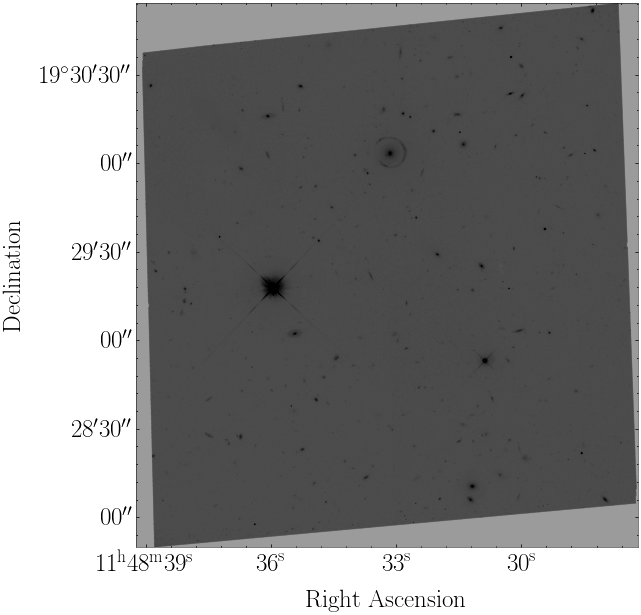

In [7]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=1000))
# plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination');

# Find a patch of dark sky to estimate noise

In [8]:
# Right ascension	11h 48m 33.1s
# Declination	19° 30′ 03″
centroid = SkyCoord(177.13808, 19.50089, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid # in pixel space

(array(2176.48364204), array(3361.47934944))

In [9]:
bkg_centroid = SkyCoord("11h48m30.1s", "+19.50089", unit=(u.hourangle, u.deg))
bkg_centroid = bkg_centroid.to_pixel(wcs)
x0, y0 = bkg_centroid
x1 = x0 - 150
x2 = x0 + 150
y1 = y0 - 150
y2 = y0 + 150
bkg_centroid # in pixel space

(array(3261.11020582), array(3361.52172117))

In [10]:
size = 300 * u.pixel
bkg_cutout = Cutout2D(image, bkg_centroid, size, wcs=wcs)
bkg_cutout_image = bkg_cutout.data
bkg_wcs_cutout = bkg_cutout.wcs
# cutout_image[cutout_image < 0] = 0

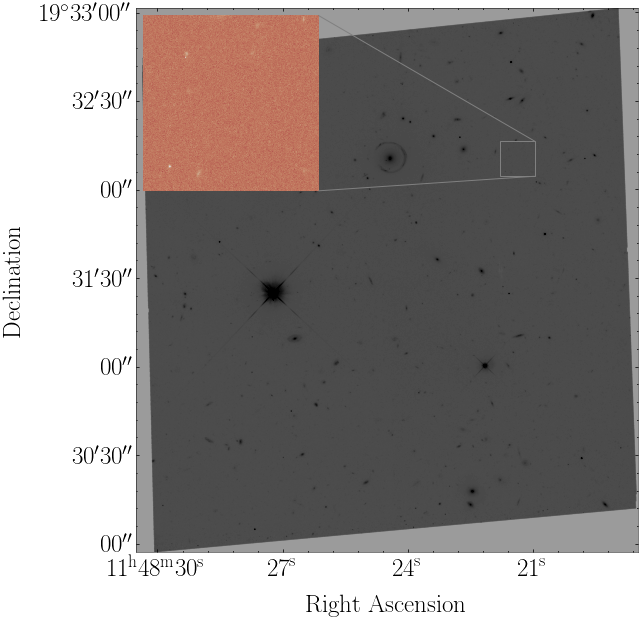

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
# plt.title("")
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=1000))

ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
extent=[0, image.shape[1], 0, image.shape[0]]
axins = zoomed_inset_axes(ax, 5, loc=2) # zoom = 6
axins.imshow(image, interpolation="nearest", extent=extent, origin="lower", cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmax=500))
axins.axis("off")
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

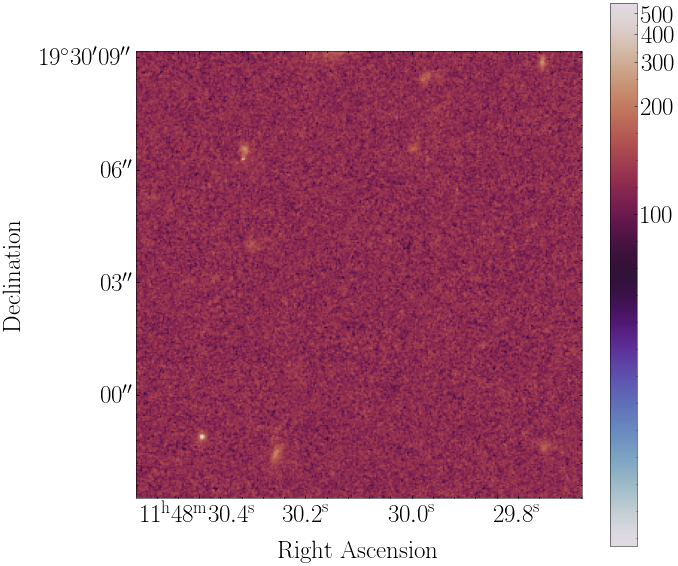

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
plt.imshow(bkg_cutout_image , cmap="twilight", norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

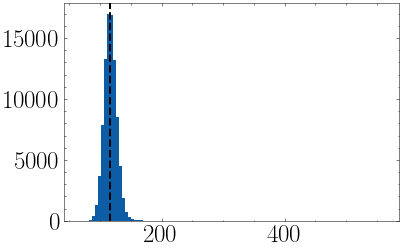

In [13]:
plt.hist(bkg_cutout_image.ravel(), bins=100);
plt.axvline(np.mean(bkg_cutout_image), ls="--", lw=2, color="k")

In [15]:
bkg = np.mean(bkg_cutout_image)
std_bkg = np.std(bkg_cutout_image)
bkg, std_bkg

(116.77832, 10.967095)

# Find a PSF candidate around the Horseshoe

In [16]:
size = 3000 * u.pixel
psf_cutout = Cutout2D(image, centroid, size, wcs=wcs)
psf_cutout_image = psf_cutout.data
psf_wcs_cutout = psf_cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [30]:
daofind = DAOStarFinder(fwhm=1, threshold=200.*std_bkg)
sources = daofind(psf_cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
object_positions = sources["xcentroid", "ycentroid"].to_pandas().to_numpy()
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[1:5]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
2,495.467112822597,312.2711029899701,0.9478059227313763,-0.03835193436797218,0.8102734980897595,25,0.0,528786.125,140.24084798809108,-5.367186322806959
3,478.92047850262946,335.20646519220867,0.9351801387126872,0.18279764490009384,0.4135705508350738,25,0.0,14059.7958984375,1.7809638268919856,-0.6266377465234327
4,509.10787121142295,336.15238660205296,0.9073950649426761,-0.6773785213763835,-0.4011699552757437,25,0.0,13071.9443359375,1.1337807499579176,-0.13632269748226994
5,492.2633676040839,337.25568338403895,0.9877033902931031,-0.05996964469917474,-0.05978598658284789,25,0.0,439830.09375,91.91290886696453,-4.9084412772678405


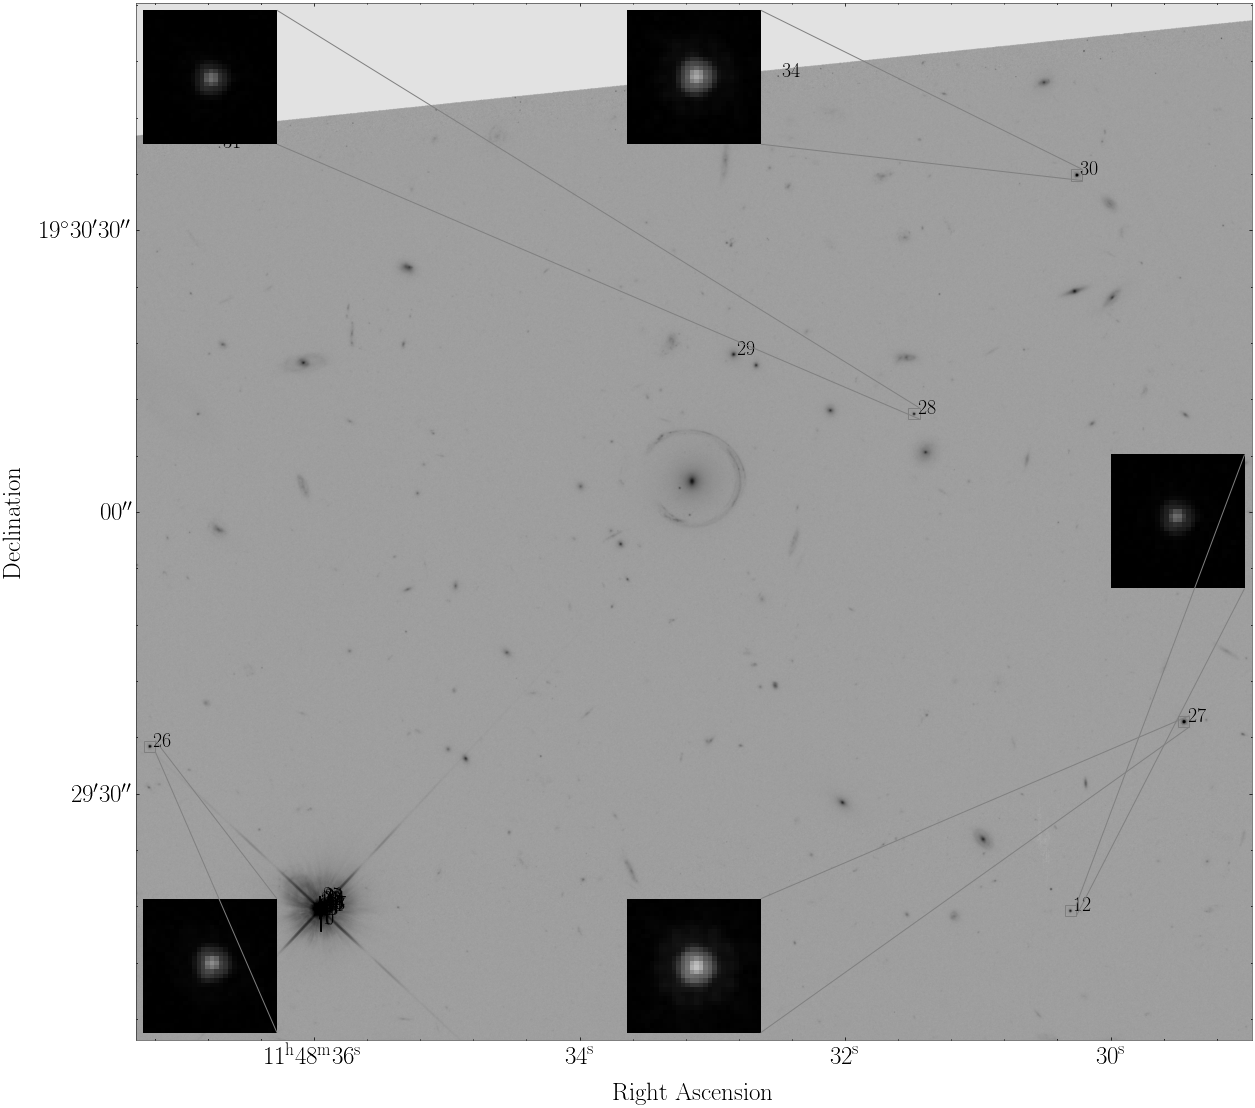

In [59]:
plt.figure(figsize=(20, 20))
plt.subplot(projection=psf_wcs_cutout)
# plt.title("")
plt.imshow(psf_cutout_image-bkg, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=10000))

ax = plt.gca()
for i in range(len(sources)):
    ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="k", fontsize=20)


extent=[0, psf_cutout_image.shape[1], 0, psf_cutout_image.shape[0]]

d = 15


k = 28
axins = zoomed_inset_axes(ax, 12, loc=2) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 30
axins = zoomed_inset_axes(ax, 12, loc=9) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

# k = 28
k = 26
axins = zoomed_inset_axes(ax, 12, loc=3) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 27
axins = zoomed_inset_axes(ax, 12, loc=8) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 12
axins = zoomed_inset_axes(ax, 12, loc=7) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

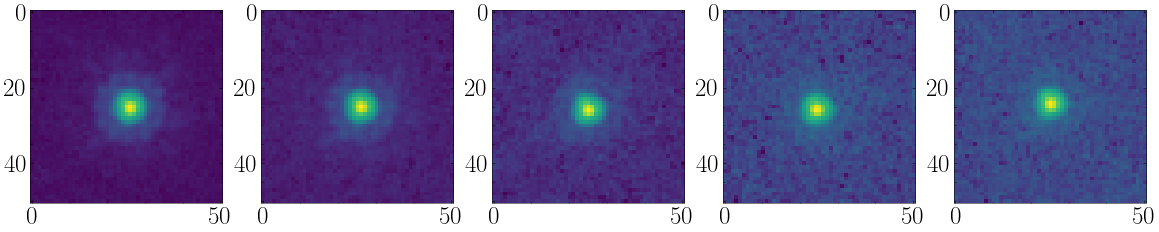

In [160]:
indices = [27, 30, 26, 12, 28]
stars = []
stars_tbl = Table()
stars_tbl['x'] = [0,]*len(indices)
stars_tbl['y'] = [0,]*len(indices)
nddata = NDData(data=psf_cutout_image - bkg)
for j, i in enumerate(indices):
    stars_tbl['x'][j] = ox[i]
    stars_tbl['y'][j] = oy[i]
#     x, y = np.round(ox[i]), np.round(oy[i])
#     size = 50 * u.pixel
#     stars.append(np.maximum(Cutout2D(psf_cutout_image, (psf_x, psf_y), size, wcs=wcs).data - bkg, 0))

stars = extract_stars(nddata, stars_tbl, size=50)


fig, axs = plt.subplots(1, len(stars), figsize=(4*len(stars), 4))
for i in range(len(stars)):
    axs[i].imshow(stars[i], norm=ImageNormalize(stretch=LogStretch()))

In [161]:
epsf_builder = EPSFBuilder(oversampling=1, maxiters=10, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)
psf = np.maximum(epsf.data, 0)
psf /= psf.sum()

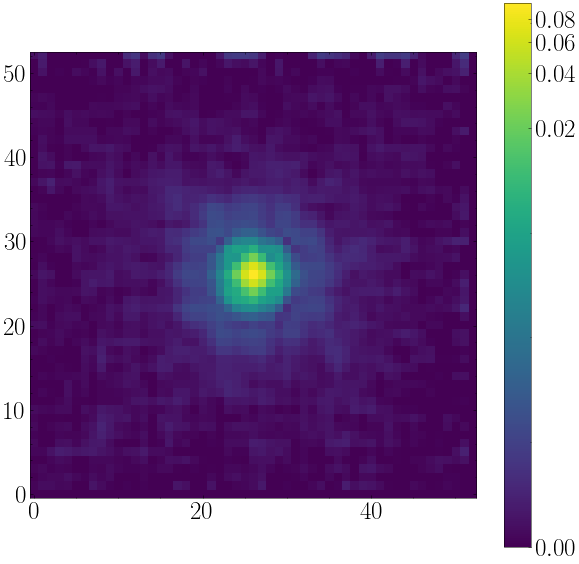

In [162]:
plt.figure(figsize=(10, 10))
plt.imshow(psf, norm=ImageNormalize(stretch=LogStretch()), origin='lower', cmap='viridis')
plt.colorbar()


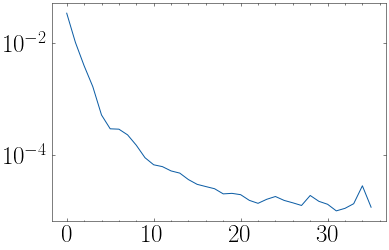

In [163]:
center = (psf.shape[0]/2,)*2
plt.plot(radial_profile(psf, center))
plt.yscale("log")
# plt.axhline(14)

# Make the Horshoe cutout

In [165]:
size = 512 * u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [195]:
daofind = DAOStarFinder(fwhm=1.0, threshold=100)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[8, 7, 5, 0]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # G, 01, 02, 03
ox, oy = object_positions[:, 0], object_positions[:, 1]

# sources

In [196]:
x = np.linspace(-1, 1, cutout_image.shape[0]) * cutout_image.shape[0]
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = r < 400

In [197]:
noise = np.random.normal(size=cutout_image.shape, scale=noise_sigma_bkg) * (1 - mask)

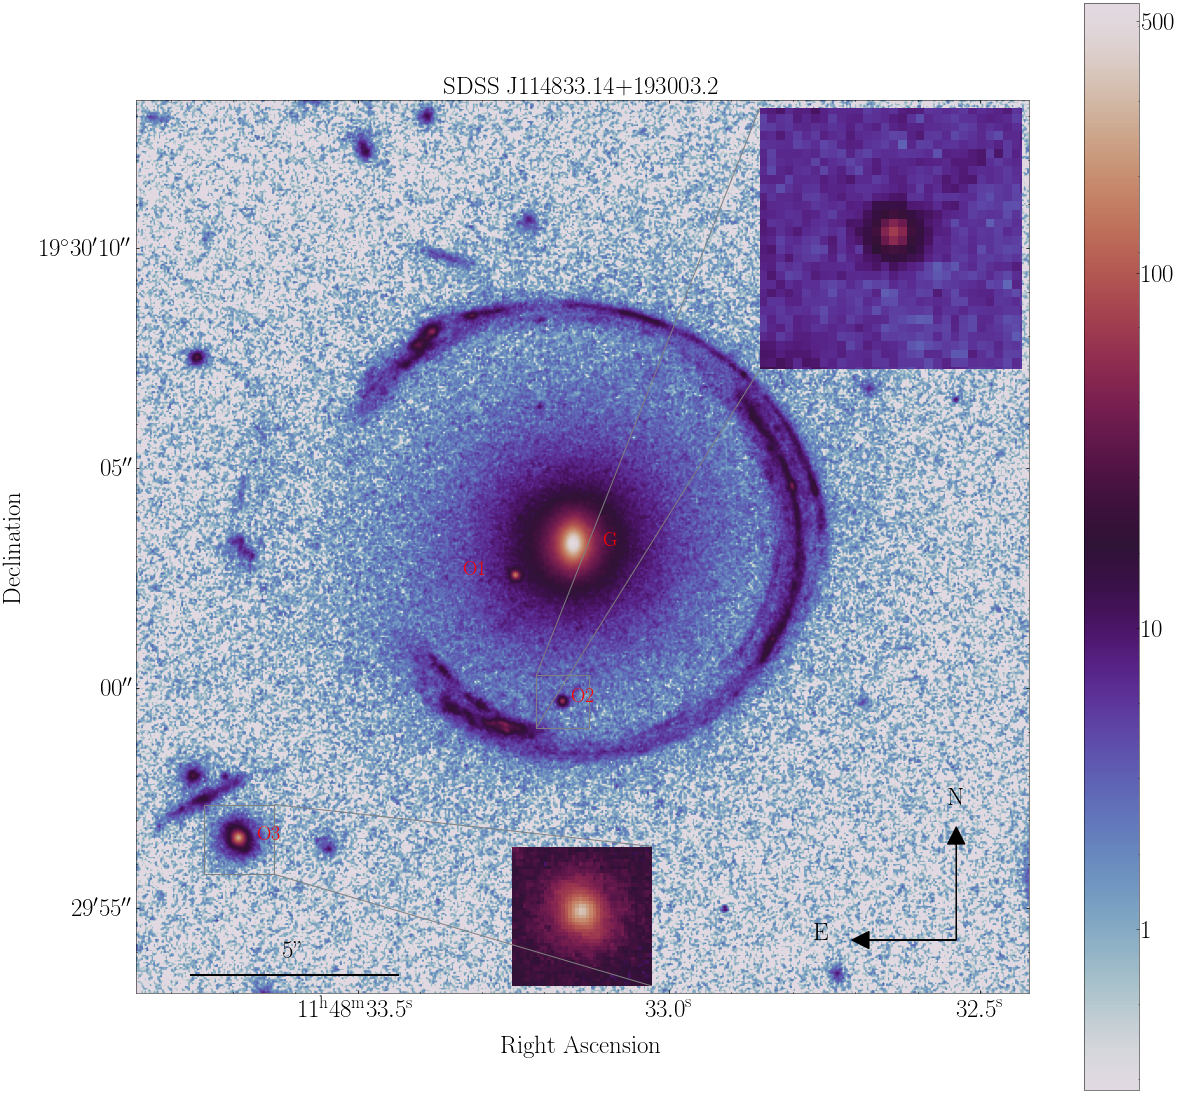

In [203]:
plt.figure(figsize=(20, 20))
plt.subplot(projection=wcs_cutout)
# plt.imshow(mask * (cutout_image - bkg) + noise, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()))
plt.imshow((cutout_image - bkg)/noise_sigma_bkg, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0))
plt.colorbar(ticks=[1, 10, 100, 500])

ax = plt.gca()

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

# for i in range(len(sources)):
#     ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="r", fontsize=20)
ax.annotate("G",  [ox[0]+15, oy[0]], color="r", fontsize=20)
ax.annotate("O1",  [ox[1]-30, oy[1]], color="r", fontsize=20)
ax.annotate("O2",  [ox[2]+5, oy[2]], color="r", fontsize=20)
ax.annotate("O3",  [ox[3]+10, oy[3]], color="r", fontsize=20)

k = 3
d = 20
extent=[0, cutout_image.shape[1], 0, cutout_image.shape[0]]
axins = zoomed_inset_axes(ax, 2, loc=8)
axins.imshow((cutout_image - bkg)/(noise_sigma_bkg + np.sqrt(np.abs(cutout_image))), interpolation="nearest", extent=extent, origin="lower", cmap="twilight", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");


k = 2
d = 15
extent=[0, cutout_image.shape[1], 0, cutout_image.shape[0]]
axins = zoomed_inset_axes(ax, 5, loc=1)
axins.imshow((cutout_image - bkg)/noise_sigma_bkg, interpolation="nearest", extent=extent, origin="lower", cmap="twilight", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5");

N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#coordinate array
arrow_size = 0.02
color="k"
font_size = 25
width = 500
d0 = 30
p0 = 50
pt = 70

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + 1.1*p0
xx_ra_t, yy_ra_t = xx_ - 1.1*pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + 1.1*pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

#scale bar
p0 = 150
dist = 5 / deltaPix
ax.plot([p0, p0 + dist], [10, 10], linewidth=2, color="k")
ax.text(p0 + dist / 2., 20, "5''", fontsize=font_size, color="k", ha='center')

ax.set_title("SDSS J114833.14+193003.2");

In [201]:
noise_sigma_poisson = np.sqrt(np.abs(cutout_image))

In [88]:
# from skimage.transform import resize
# im = resize(cutout_image - bkg, [128, 128])
# plt.figure(figsize=(10, 10))
# plt.imshow(im, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0), origin="lower")

# Galfit G, O1 and O2

In [ ]:
from lenstronomy.data import PSF


# kwargs_model = {'lens_light_model_list': lens_light_model_list}
# kwargs_constraints = {}
# kwargs_likelihood = {'check_bounds': True}

# image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
# multi_band_list = [image_band]
# kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [ ]:
# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# first Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# second Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .5, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'Rs': 0.7, 'center_x': 3., 'center_y': 0.})
kwargs_lens_light_sigma.append({'Rs': 0.3, 'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens_light.append({'Rs': 0.01, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()